In [1]:
import json
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# Milestone 2; 10,000 battles Project

[NBViewer](https://nbviewer.jupyter.org/github/ChristianMct/ADA2017-Homeworks/blob/master/project/milestone_2.ipynb)

## Tasks Description

Milestone 2 (20%): the project repo contains a notebook with data collection and descriptive analysis, properly commented, and the notebook ends with a more structured and informed plan for what comes next.

The tasks involving a large amount of data were pre-run and we simply describe their purposes and outputs while showing how to call them in comments.

## Data Collection

Data collection was a significant part of our work, given the nature of our original dataset. The task was to go from a 44 Gb large wikipedia dump to clean and normalized features about each battle. As it was shown during the lecture, data collection is in fact an iterative process: new needs in the analysis part may require new data to be extracted, or different transformation applied. Thus, the data collection was organized into a **pipeline** of 3 operations, in order to achieve **composability** and **reproducibility**. We know explain this pipeline as a part of this notebook, the actual code being organized as **python modules**, much more suited for data processing than notebooks.

Each step of the pipeline is a **python script** in the `processing` folder. They have the following usage:

```shell
python script.py file-name-in file-name-out
```

For the sake of reproducibilty and organization, we used a naming convention for the output files including what step of the pipline was run, and the version of this dataset. Each version of the dataset is then associated with a git tag marking the state of the codebase that generated the file, to avoid confusion when coming back to the very begining of the pipeline each time we have a doubt (see README in the `datasets/` folder). We know describe each of the 3 pipeline operation.

### Page extraction

**Script**: `page_extraction.py`<br />
**Environmnent**: Cluster<br />
**Input**: `hdfs:///datasets/wikipedia/enwiki-latest-pages-articles-multistream.xml` (~44 Gb)<br />
**Output**: `battle-pages-v.json` (~123 Mb)<br />
**Description**:<br />
Pages extraction has two main goals, it selects what pages are (entierly) kept in the next step using a regular expression in the title (may be refined later, if we find a better way to isolate a battle related page), and translate from an XML to a JSON representation for easier python processing. It leverages on [pySpark's DataFrame](https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html) and its custom [XML data-source from Databricks](https://github.com/databricks/spark-xml) to provide an SQL-like, parallelized Spark job.


### Fields extraction

**Script**: `fields_extraction.py`<br>
**Envir.**: Local<br>
**Output**: `battle-fields-v.json` (~14 Mb)<br>
**Description**:<br>
This step's purpose is to extract key-value pairs from the raw page [Wikitext](https://www.mediawiki.org/wiki/Wikitext), where keys are identifiers of information contained in the page and values are either a `dict` of other key-values pairs, a `list` of string, or a string (mainly, strings that are actually wikitext). In other words, we parse the page into a tree-like structure on which it will be easier to parse and extract actual features afterward. We mainly (but not exclusively) relied on the presence of an `infobox` [template](https://en.wikipedia.org/wiki/Help:Template) for most of the battle pages. Again, each line contains the tree of a battle. Therefore:

In [2]:
# We can load all the battle trees like this
battles = [json.loads(line) for line in open('datasets/battle-fields-1.json')]
print("Number of pages or battles pages", len(battles))

Number of pages or battles pages 27255


We then perform some preliminary assessments about the current state of the dataset.

In [3]:
errors = [b.get('infobox').get('error') for b in battles]
no_infoboxes = sum([1 for e in errors if e=="no infobox"])
more_infoboxes = sum([1 for e in errors if e=="more than one infobox"])

print("Number of pages that do not contain an infobox ", no_infoboxes)
print("Number of pages that contains more than one infobox ", more_infoboxes)
print("Number of pages that do contain an infobox ", len(battles)-no_infoboxes-more_infoboxes)

Number of pages that do not contain an infobox  19752
Number of pages that contains more than one infobox  17
Number of pages that do contain an infobox  7486


We immediately see that the number of page we can extract information from is greately reduced. It later came out that many of the pages in the dump are alias, redirects and discussion pages. However, the new battle count is still comfortably high to provide interesting analysis.

We then assess the actual population of the extractable keys, so that we know on what field we can focus our feature extraction effort:

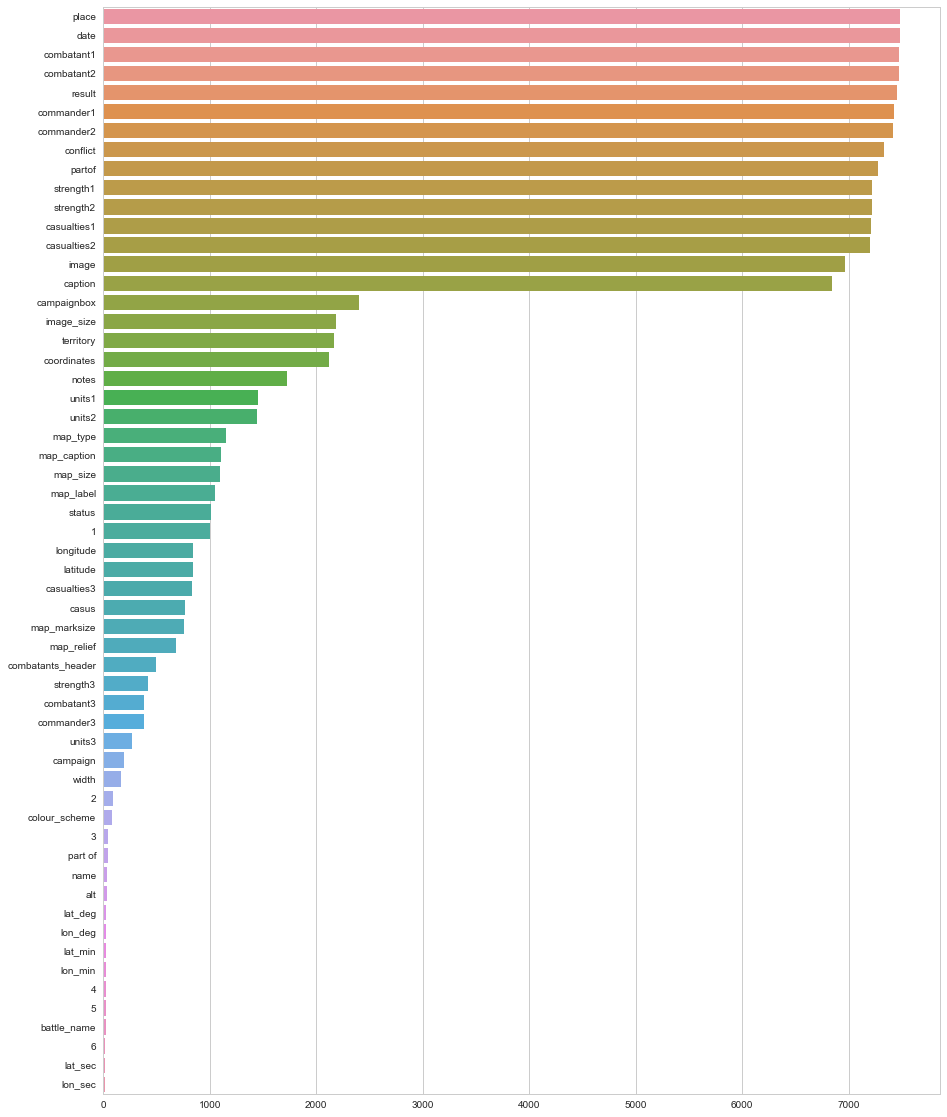

In [4]:
df = pd.DataFrame([b["infobox"] for b in battles if not b["infobox"].get("error")])
f, ax = plt.subplots(figsize=(15, 20))
counts = df.count().sort_values(ascending=False)
counts = counts[counts > 20]
sns.barplot(x=counts, y=counts.index, ax=ax)
plt.show()

Based on these observations, we selected the following set of features to be extracted from the key-value pairs by the next pipeline step (we may add more of them later):
- date
- coordinates
- combatants (combatant1, ...)
- result
- strengths (strength1, ...) in terms of number of men
- casualties (casualties1, ...) in terms of number of men killed/wounded/captured

### Features extraction

**Script**: `features_extraction.py`<br />
**Envir.**: Local<br />
**Output**: `battle-features-v.json` (~4.1 Mb)
**Description**:<br>
The final step extract a "flat" set of key-value from the preivious step's tree (e.i., values cannot be another `dict`) that we call features. It does so by first further parsing and transforming values from the previous step into a normalized representation, possibly combining multiple ones togheter. This was indeed the most time-consuming part of the current implementation, as it involves parsing sometime highly variable, unormalized free-text data. We elaborate on this aspect for some features in the following subsections. Each of line in the output file contains such set, so it can be convieniently imported in a `pandas.DataFrame` object.

In [5]:
battles = pd.DataFrame([json.loads(line) for line in open("datasets/battle-features-0.json")])
print(battles.count())
demo_col = ["combatant_first_1", "combatant_first_2", "result_combatant_1", "result_combatant_2", "start_date", "end_date", "casualties_1", "casualties_2"]
battles[demo_col].head()

captured_1              7486
captured_2              7486
captured_3              7486
captured_4              7486
casualties_1            7486
casualties_2            7486
casualties_3            7486
casualties_4            7486
combatant_first_1       7205
combatant_first_2       7187
combatant_first_3         25
combatant_list_1        7486
combatant_list_2        7486
combatant_list_3        7486
dates_bc                7409
end_date                2716
indecisive              7486
killed_1                7486
killed_2                7486
killed_3                7486
killed_4                7486
latitude                3766
longitude               3766
missing_1               7486
missing_2               7486
missing_3               7486
missing_4               7486
result_combatant_1      7486
result_combatant_2      7486
result_combatant_3      7486
source                  7486
start_date              6799
strategic_indecisive    7486
strength_1              7486
strength_2    

,combatant_first_1,combatant_first_2,result_combatant_1,result_combatant_2,start_date,end_date,casualties_1,casualties_2
0,Julius Caesar,Pompey,decisive victory,,0048-08-09,None,230,10500
1,Royalists,Parliamentarians,victory,,1644-08-13,1644-09-02,0,0
2,Kingdom of England,Kingdom of France,decisive victory,,1356-09-19,None,0,4500
3,Teutonic Order,Kingdom of Poland,,decisive victory,1462-09-17,None,1050,250
4,United States,Empire of Japan,victory,,1944-09-15,1944-11-27,10786,10897


## Descriptive analysis

We provide a succint descriptive analysis for the main features. 

### Geolocation

We begin by showing the geographical coverage of our dataset. This seems to be consistent with the location of wars across history.

In [6]:
from folium.plugins import HeatMap
import folium as fl
m = fl.Map()
coord_df = battles[["latitude", "longitude"]].dropna()
coords = [[lat, long] for lat, long in zip(coord_df["latitude"], coord_df["longitude"])]
HeatMap(coords).add_to(m)
m

### Dates

We continue by looking at the time domain coverage. It looks like we have a pretty uniform one.

In [7]:
import datetime
dates = battles[battles.start_date.notna()].start_date
date_bc = battles[battles.start_date.notna()].dates_bc

X=[datetime.datetime.strptime(date, "%Y-%m-%d") for date, bc in zip(dates, date_bc) if not bc]
fig, ax = plt.subplots(figsize=(20,1))
ax.scatter(X, [1]*len(X),
           marker='|', s=100)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
day = pd.to_timedelta("1", unit='D')
plt.xlim(X[0] - day, X[-1] + day)
plt.show()

AttributeError: 'Series' object has no attribute 'notna'

We group here all our functions to plot:

In [8]:
def densplot(columns, xlabel, title, axo):
    for i,v in enumerate(columns):
        sns.distplot(v, ax=axo, kde_kws={"label": i})
    axo.set_title(title)
    axo.set_xlabel(xlabel, fontsize=12)
    
def scatplot(xelem, yelem, xlabel, ylabel, title, axo, polyfit=None):
    axo.scatter(xelem, yelem)
    if polyfit:
        plt.plot(np.unique(xelem), np.poly1d(np.polyfit(xelem, yelem, polyfit))(np.unique(xelem)), 'C2')
    axo.set_title(title)
    axo.set_xlabel(xlabel, fontsize=12)
    axo.set_ylabel(ylabel, fontsize=12)

In [9]:
battles = [json.loads(line) for line in open("datasets/battle-features-0.json")]
df = pd.DataFrame(battles).replace(0, np.NaN)

#### Casualties

A battle has at maximum casualties for 4 different combatants ("casualties_1", "casualties_2", ...). And each casualties information can contain a number of people "killed", "wounded", "missing" or "captured". When possible, we also fetched (parsed) these data. We have observed that for multiple battles, wikipedia was referencing multiple sources for the same number and we handled this by doing the average of the values. We also did the average for range values. 

In [10]:
df[['killed_1', 'wounded_1', 'missing_1', 'captured_1', 'casualties_1']].head()

,killed_1,wounded_1,missing_1,captured_1,casualties_1
0,NaN,NaN,NaN,NaN,230.0
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,1000.0,NaN,NaN,50.0,1050.0
4,2336.0,8450.0,NaN,NaN,10786.0


In [11]:
df[['killed_1', 'wounded_1', 'missing_1', 'captured_1', 'casualties_1', 'killed_2', 'wounded_2', 'missing_2', 'captured_2', 'casualties_2']].count()

killed_1        2689
wounded_1       1568
missing_1        248
captured_1       527
casualties_1    4392
killed_2        2694
wounded_2       1145
missing_2        181
captured_2       848
casualties_2    4496
dtype: int64

We observe that the casualties is sometime defined by the number of killed and wounded people but we notice that most of the time, only the total number is available.
We focus on the total number of casualties for this descriptive analysis and will go into more details in the future exploratory analysis.

We observe that the dataset contains a lot of NaN values. This is mainly because there is no numeric information for the casualties. In our data extraction pipeline we have observed that casualties_1 and casualties_2 contain only 79 and 80 lines (battles) that have a numeric information but cannot be parsed.  

number of null values
casualties_1    3094
casualties_2    2990
casualties_3    7257
casualties_4    7481
dtype: int64
number of non null values
casualties_1    4392
casualties_2    4496
casualties_3     229
casualties_4       5
dtype: int64


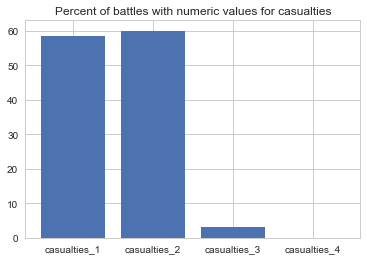

In [12]:
sums_null = df[['casualties_1', 'casualties_2', 'casualties_3', 'casualties_4']].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(df))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(df)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We also observe that almost 60% of the battles have numeric values for two combatants ("casualties_1" and "casualties_2"). We also notice that casualties_1 and 2 have more data points than the other. This makes sense as we can usually consider two opposite sides in a battle.
Each casualties feature has an average of:

In [13]:
averages = df[['casualties_1', 'casualties_2', 'casualties_3', 'casualties_4']].mean()
print(averages)

casualties_1    4935.335838
casualties_2    8863.042482
casualties_3    4403.401747
casualties_4    1292.200000
dtype: float64


We can see that the average for 1 and 3 are close, while casualties_2 is higher. This may indicate that usually the combatant 2 (to which corresponds casualties_2) is usually the looser of the battle. Even though it is too early to jump to conclusions !!
In the following, we observe the distributions of the features. Since casualties_4 only has 5 data points, we do not use it in our analysis. Moreover, we have observed similar distributions for the different features and thus only display for casualies_1.

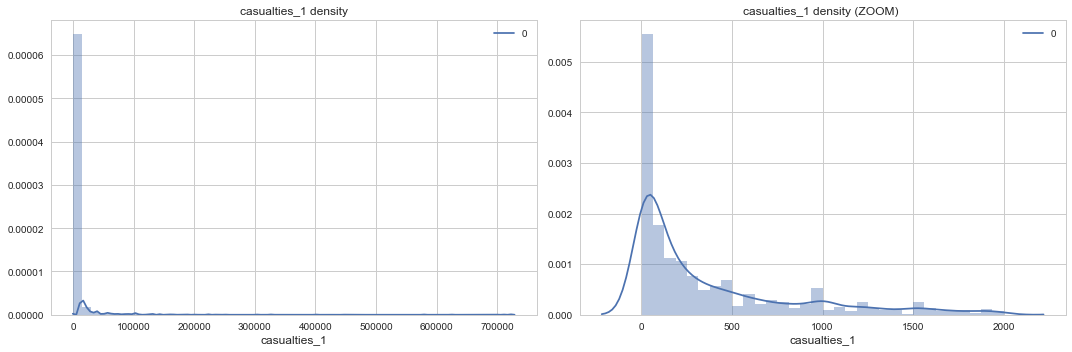

In [31]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([df['casualties_1'].dropna()], 'casualties_1', "casualties_1 density", ax1)
densplot([df.query('2000 > casualties_1 >1')['casualties_1']], 'casualties_1', "casualties_1 density (ZOOM) ", ax2)
fig.tight_layout()
plt.show()

We observe that all casualties are pretty sparsed in their values while they all have there peak for small casualties values. By "zooming", we observe that most of the values are between 0 and 2000 casualties.

For the remaining of our analysis for this feature we will focus on casualties_1 (c1) and casualties_2 (c2).
We first observe that 3782 out of the 4392 (min(#casualties_1, #casualties_2)) battles have information on two combatants' casualties.

In [15]:
print("number of battles with values for c1 and c2: ", (len(df.query('0 < casualties_1 and 0 < casualties_2')['casualties_1'])))

number of battles with values for c1 and c2:  3782


As a first step towards our future exploratory analysis, we can combine these two features, to see if, for example, high casualties for 1 combatant, means also high casualties for the other.

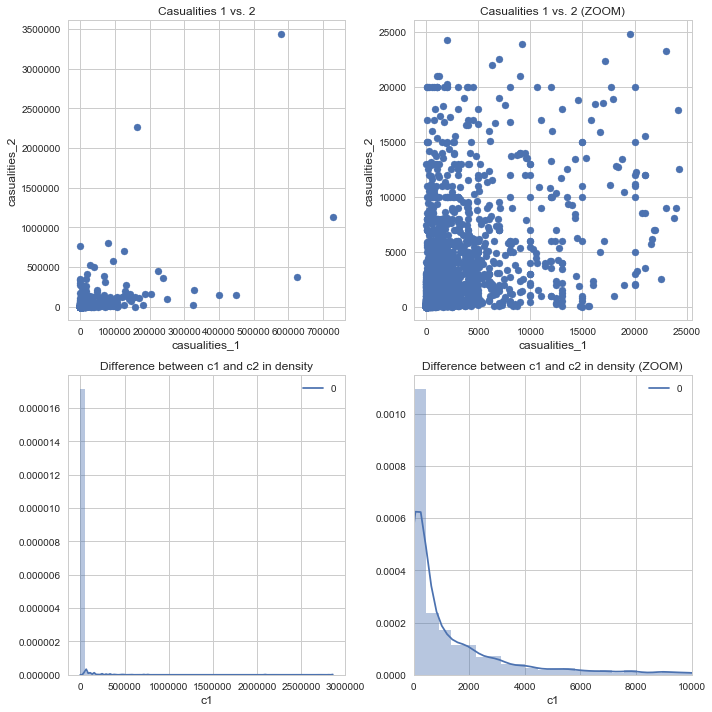

In [16]:
c1_zoom = df.query('25000 > casualties_1 >1 and 25000 > casualties_2 > 1')['casualties_1']
c2_zoom = df.query('25000 > casualties_1 >1 and 25000 > casualties_2 > 1')['casualties_2']

c1 = df.query('casualties_1 >1 and casualties_2>1')['casualties_1']
c2 = df.query('casualties_1 >1 and casualties_2>1')['casualties_2']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10,10))
scatplot(c1, c2, 'casualities_1', 'casualities_2', "Casualities 1 vs. 2", ax1)
scatplot(c1_zoom, c2_zoom, 'casualities_1', 'casualities_2', "Casualities 1 vs. 2 (ZOOM)", ax2)
densplot([abs(c1-c2)], 'c1', "Difference between c1 and c2 in density", ax3)
densplot([abs(c1_zoom-c2_zoom)], 'c1', "Difference between c1 and c2 in density (ZOOM)", ax4)
ax4.set_xlim(0,10000)
fig.tight_layout()
plt.show()

We observe that the difference between the casualties is concentrated to 0. We observe that we cannot conclude that high casualties on one side does not mean high casualties for the other.

#### Strengths

Strength is the number of men involved in a battle. A battle has at maximum strength information for 3 different combatants ("strength_1", "strength_2", ...). We also did the average for range values. 

In [17]:
df[['strength_1', 'strength_2', 'strength_3']].head()

,strength_1,strength_2,strength_3
0,22000.0,42500.0,NaN
1,NaN,NaN,NaN
2,6000.0,11000.0,NaN
3,2700.0,2000.0,NaN
4,47561.0,10900.0,NaN


We observe that the dataset contains a lot of NaN values. This is mainly because there is no numeric information for the strength. In our data extraction pipeline we have observed that strength_1 and strength_2 contain only 120 and 110 lines (battles) that have a numeric information but cannot be parsed. (this cans also be the case that it is numeric information but irrelevant, so it is not parsed on purpose.

number of null values
strength_1    2324
strength_2    2382
strength_3    7472
dtype: int64
number of non null values
strength_1    5162
strength_2    5104
strength_3      14
dtype: int64


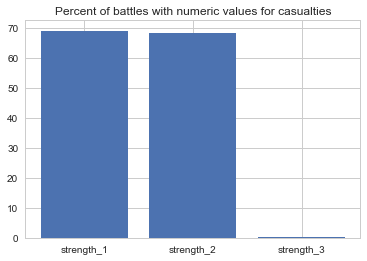

In [18]:
sums_null = df[['strength_1', 'strength_2', 'strength_3']].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(df))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(df)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We also observe that almost 70% of the battles have numeric values for two combatants ("strength_1" and "strength_2"). We also notice that strength_1 and 2 have more data points than the other. Again, this makes sense as we can usually consider two opposite sides in a battle.
Each casualties feature has an average of:

In [19]:
averages_strength = df[['strength_1', 'strength_2', 'strength_3']].mean()
print(averages_strength)

strength_1    19714.607129
strength_2    21019.709835
strength_3    20321.142857
dtype: float64


We can see that the average for the 3 features is pretty similar. This may indicate that usually the battles oppose two sides that have a similar number of fighters.
We observe the distributions of the features: (Again we will focus on the first two as the last one only has 14 data points)

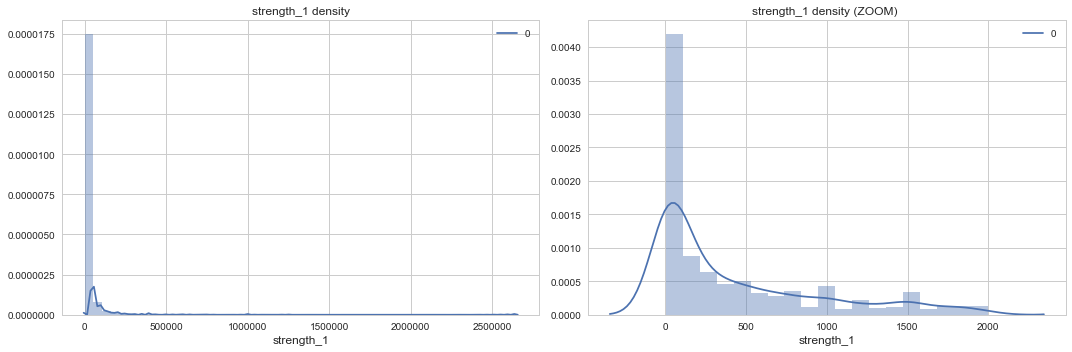

In [33]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([df['strength_1'].dropna()], 'strength_1', "strength_1 density", ax1)
densplot([df.query('2000 > strength_1 >1')['strength_1']], 'strength_1', "strength_1 density (ZOOM) ", ax2)

fig.tight_layout()
plt.show()

We observe similar results as for casualties, in fact strength 1,2 and 3 are all pretty sparsed (we only display for strength_1) in their values while they all have there peak for small strength values. By "zooming", we observe that most of the values are between 0 and 2000 for strength.

For the remaining of our analysis for this feature we will focus on strength_1 (s1) and strength_2 (s2).
We first observe that 4383 out of the 5104 (min(#strength_1, #strength_2)) battles have information on two combatants' strengths.

In [21]:
print("number of battles with values for s1 and s2: ", (len(df.query('1 < strength_1 and strength_2 > 1')['strength_1'])))

number of battles with values for s1 and s2:  4383


We now combine these two features, to see if, for example, high strength for 1 combatant, means also high strength for the other, as the average and distribution results tend to show.

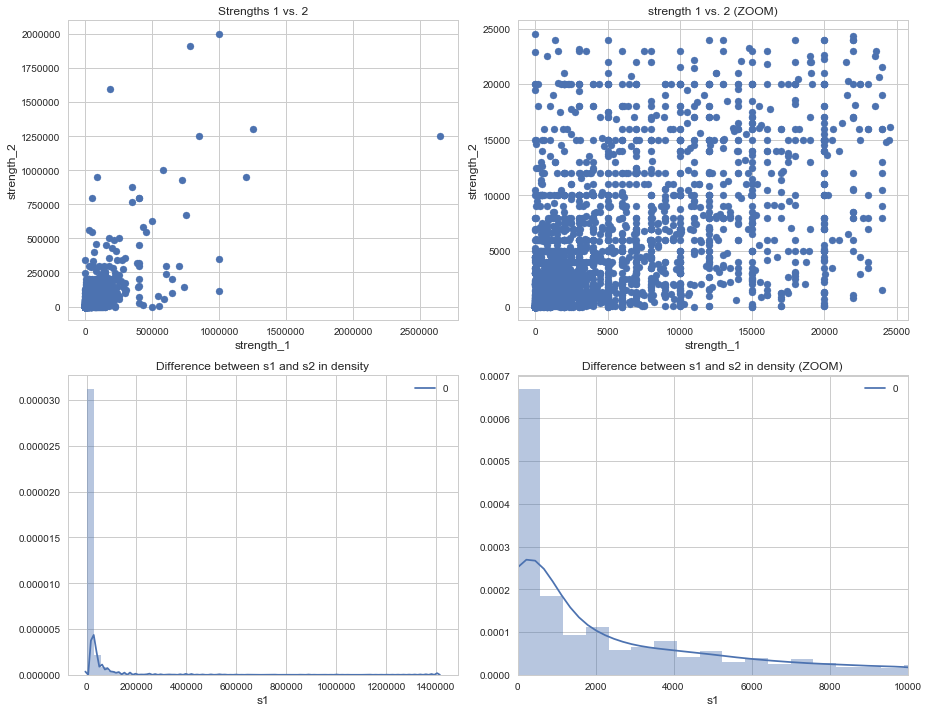

In [22]:
s1_zoom = df.query('25000 > strength_1 >1 and 25000 > strength_2 > 1')['strength_1']
s2_zoom = df.query('25000 > strength_1 >1 and 25000 > strength_2 > 1')['strength_2']

s1 = df.query('strength_1 >1 and strength_2>1')['strength_1']
s2 = df.query('strength_1 >1 and strength_2>1')['strength_2']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(13,10))
scatplot(s1, s2, 'strength_1', 'strength_2', "Strengths 1 vs. 2", ax1)
scatplot(s1_zoom, s2_zoom, 'strength_1', 'strength_2', "strength 1 vs. 2 (ZOOM)", ax2)
densplot([abs(s1-s2)], 's1', "Difference between s1 and s2 in density", ax3)
densplot([abs(s1_zoom-s2_zoom)], 's1', "Difference between s1 and s2 in density (ZOOM)", ax4)
ax4.set_xlim(0,10000)
fig.tight_layout()
plt.show()

These first results tend to show that usually the battles oppose two sides with a close strength. Indeed, the difference between the two strength is usually small. We also observe that, the number seems to be pretty often round up in wikipedia by looking at the top right graph where we can see kind of grid patterns.

#### Combatants

A battle has at maximum 3 different combatants ("combatant_1", "combatant_2", ...). We have noticed that wikipedia often contains multiple combatants in one combatant feature. For examples, during the world war, the battles usually opposed two sides while each side was made of an alliance of multiple combatants. Thus, we retrieve the main combatant and a list of all the combatants present for each battle for each feature.

In [23]:
df[['combatant_first_1', 'combatant_list_1', 'combatant_first_2', 'combatant_list_2']].head()

,combatant_first_1,combatant_list_1,combatant_first_2,combatant_list_2
0,Julius Caesar,"[Julius Caesar, Populares]",Pompey,"[Pompey, Optimates]"
1,Royalists,[Royalists],Parliamentarians,[Parliamentarians]
2,Kingdom of England,"[Kingdom of England, Principality of Wales, Du...",Kingdom of France,"[Kingdom of France, Kingdom of Scotland]"
3,Teutonic Order,[Teutonic Order],Kingdom of Poland,[Kingdom of Poland]
4,United States,[United States],Empire of Japan,[Empire of Japan]


number of null values
combatant_first_1     281
combatant_first_2     299
combatant_first_3    7461
dtype: int64
number of non null values
combatant_first_1    7205
combatant_first_2    7187
combatant_first_3      25
dtype: int64


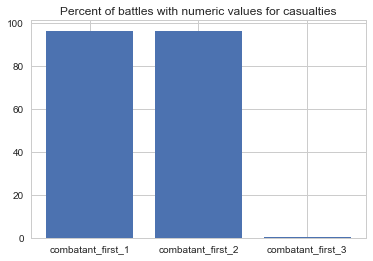

In [24]:
sums_null = df[['combatant_first_1', 'combatant_first_2', 'combatant_first_3']].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(df))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(df)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We observe that in contrary with the previous features, most of the battles contain information about the combatants. Again most of the battles are between two (group of) combatants.

Since the number of different combatants is pretty high: 4719. We will show here the 50 combatants that participated in the higher number of battles. An not surprisingly (!), the U.S. are first, right before France and Spain.

[]

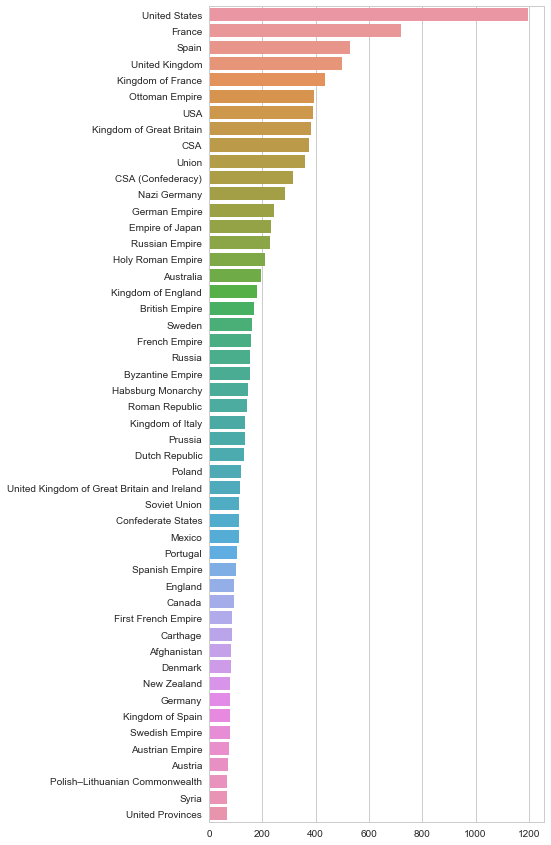

In [25]:
cbt_1 = np.array(df["combatant_list_1"].dropna())
cbt_2 = np.array(df["combatant_list_2"].dropna())
cbt_3 = np.array(df["combatant_list_3"].dropna())

cbt_all = np.concatenate((cbt_1, cbt_2, cbt_3))

all_cbt_names = [c for cl in cbt_all for c in cl]
names = pd.Series(all_cbt_names)

f, ax = plt.subplots(figsize=(6, 15))
counts = names.value_counts().sort_values(ascending=False)
counts = counts.head(50)
sns.barplot(x=counts, y=counts.index, ax=ax)
plt.plot()

#### Results

When parsing the battles' results, we mapped them to a qualifier and a result type.
A qualifier can be: "decisive", "major", "crushing", "tactical" or "strategic", while the result type is in: "victory", "defeat", "retreat".
The results correspond then to each combatant (or group of combatant).

In [26]:
df[['result_combatant_1','result_combatant_2','result_combatant_3', 'indecisive', 'tactical_indecisive', 'strategic_indecisive']].head()

,result_combatant_1,result_combatant_2,result_combatant_3,indecisive,tactical_indecisive,strategic_indecisive
0,decisive victory,,,False,False,False
1,victory,,,False,False,False
2,decisive victory,,,False,False,False
3,,decisive victory,,False,False,False
4,victory,,,False,False,False


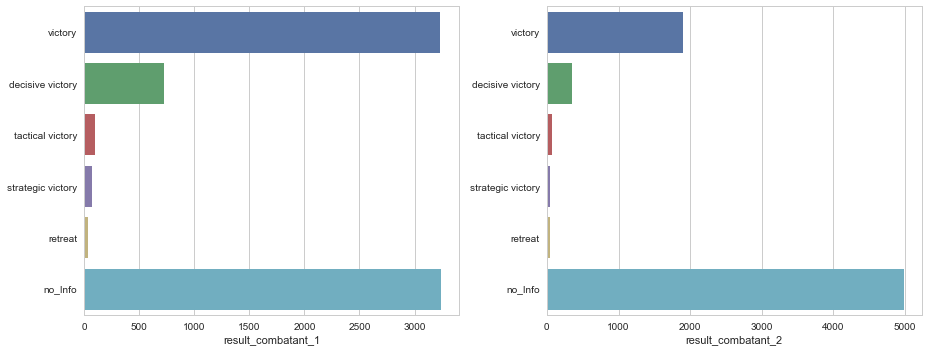

In [38]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,5))
counts1 = df['result_combatant_1'].value_counts().sort_values(ascending=False)
counts1 = counts1.head(6)
counts1["no_Info"] = counts1[""]
del counts1[""]
sns.barplot(x=counts1, y=counts1.index, ax=ax1)
counts2 = df['result_combatant_2'].value_counts().sort_values(ascending=False)
counts2 = counts2.head(6)
counts2["no_Info"] = counts2[""]
del counts2[""]
sns.barplot(x=counts2, y=counts2.index, ax=ax2)
fig.tight_layout()

We observe that for each feature, the number of empty values (no_info) is high (about 45% of the dataset for combatant_1).
We also observe that the most present type is victory, while the qualifier of the victory is precised in some cases.

We provide here the new version of our readme: